Yeah, so I'm going to try to make some predictions about small business loans and whether or not they're advisable here. I think that ultimately I may end up trying to use neural networks here, which means that I'll have to move to either Google Colab or IBM Watson, but I think that I can go ahead and do the data exploration here. My hope is to spend about an hour a day on this project, and to complete the cleaning and exploration this week.

I want to answer three related questions:
1. What is the likelihood that a given loan will go into default
2. How long will the loan take to go into default
3. What is the expected value of the principal paid

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/rebekaharana/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sba = pd.read_csv("SBAnational.csv", parse_dates = ["ApprovalDate", "ChgOffDate", "DisbursementDate"])

/Users/rebekaharana/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pd.options.display.max_columns = 35

sba.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997-02-28,1997,84,4,2.0,0,0,1,0,N,Y,NaT,1999-02-28,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,1997-02-28,1997,60,2,2.0,0,0,1,0,N,Y,NaT,1997-05-31,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,1997-02-28,1997,180,7,1.0,0,0,1,0,N,N,NaT,1997-12-31,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,1997-02-28,1997,60,2,1.0,0,0,1,0,N,Y,NaT,1997-06-30,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,1997-02-28,1997,240,14,1.0,7,7,1,0,N,N,NaT,1997-05-14,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [4]:
# Let's check what sort of data types we have here

sba.dtypes

LoanNr_ChkDgt                 int64
Name                         object
City                         object
State                        object
Zip                           int64
Bank                         object
BankState                    object
NAICS                         int64
ApprovalDate         datetime64[ns]
ApprovalFY                   object
Term                          int64
NoEmp                         int64
NewExist                    float64
CreateJob                     int64
RetainedJob                   int64
FranchiseCode                 int64
UrbanRural                    int64
RevLineCr                    object
LowDoc                       object
ChgOffDate           datetime64[ns]
DisbursementDate     datetime64[ns]
DisbursementGross            object
BalanceGross                 object
MIS_Status                   object
ChgOffPrinGr                 object
GrAppv                       object
SBA_Appv                     object
dtype: object

In [5]:
# Let's check how much missing data we have here

sba.isnull().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

Where then are we missing a whole bunch of data? Well, ```ChgOffDate``` is missing data for roughly 80% of the observations, though this is almost certainly because it is only relevent for those loans on which the borrower defaulted. Relatively little of the rest of the data is missing, so the question is then how much of this we just want to dump, and how much of it we want to try to impute. To begin with though, there are some columns that need work.

We might handle the "missing" data for ```ChgOffDate``` by setting all the null values to -1 to begin with. That way if I drop the rows with null values, I don't end up dumping all of those observations.

As far as the remaining missing data goes, let's get rid of any unwanted columns first, and then drop remaining problematic rows. At worst, they account for roughly 1.4% of our data, which seems unlikely to make a huge difference in our model.

Now, looking at the column types that we have, there's a bit of work that we need to do to begin with.
1. ```ApprovalFY``` should be an integer, rather than an object. That suggests that there are some weird entries that we need to find.
2. All of the money columns (```DisbursementGross```, ```BalanceGross```, ```ChgOffPrinGr```, ```GrAppv```, and ```SBA_Appv``` need to be stripped of their dollar signs and commas and converted to floats.


In [6]:
def currency_to_float(df1, columns):
    
    for col in columns:
        print(col)
        to_transform = df1[col].tolist()
        transformed = [float(''.join(''.join(item.split(',')).split('$'))) for item in to_transform]
            
        df1[col] = transformed
    
    return df1

In [7]:
money_columns = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']

sba = currency_to_float(sba, money_columns)

DisbursementGross
BalanceGross
ChgOffPrinGr
GrAppv
SBA_Appv


In [8]:
sba.head(10)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997-02-28,1997,84,4,2.0,0,0,1,0,N,Y,NaT,1999-02-28,60000.0,0.0,P I F,0.0,60000.0,48000.0
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,1997-02-28,1997,60,2,2.0,0,0,1,0,N,Y,NaT,1997-05-31,40000.0,0.0,P I F,0.0,40000.0,32000.0
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,1997-02-28,1997,180,7,1.0,0,0,1,0,N,N,NaT,1997-12-31,287000.0,0.0,P I F,0.0,287000.0,215250.0
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,1997-02-28,1997,60,2,1.0,0,0,1,0,N,Y,NaT,1997-06-30,35000.0,0.0,P I F,0.0,35000.0,28000.0
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,1997-02-28,1997,240,14,1.0,7,7,1,0,N,N,NaT,1997-05-14,229000.0,0.0,P I F,0.0,229000.0,229000.0
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,1997-02-28,1997,120,19,1.0,0,0,1,0,N,N,NaT,1997-06-30,517000.0,0.0,P I F,0.0,517000.0,387750.0
6,1000093009,MIDDLE ATLANTIC SPORTS CO INC,UNION,NJ,7083,WELLS FARGO BANK NATL ASSOC,SD,0,1980-06-02,1980,45,45,2.0,0,0,0,0,N,N,1991-06-24,1980-07-22,600000.0,0.0,CHGOFF,208959.0,600000.0,499998.0
7,1000094005,WEAVER PRODUCTS,SUMMERFIELD,FL,34491,REGIONS BANK,AL,811118,1997-02-28,1997,84,1,2.0,0,0,1,0,N,Y,NaT,1998-06-30,45000.0,0.0,P I F,0.0,45000.0,36000.0
8,1000104006,TURTLE BEACH INN,PORT SAINT JOE,FL,32456,CENTENNIAL BANK,FL,721310,1997-02-28,1997,297,2,2.0,0,0,1,0,N,N,NaT,1997-07-31,305000.0,0.0,P I F,0.0,305000.0,228750.0
9,1000124001,INTEXT BUILDING SYS LLC,GLASTONBURY,CT,6073,WEBSTER BANK NATL ASSOC,CT,0,1997-02-28,1997,84,3,2.0,0,0,1,0,N,Y,NaT,1997-04-30,70000.0,0.0,P I F,0.0,70000.0,56000.0


In [9]:
FY_values = set(sba['ApprovalFY'].values.tolist())

print(FY_values)

{'1974', '1975', '1983', '2005', '1978', '1995', '1967', '1994', '1979', '1968', '1981', '1977', '1969', 1962, 1965, 1966, 1967, 1968, '1984', 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, '1971', 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, '1982', '2004', '1970', '1980', '1976', '1976A', '1996'}


OK, so looking at what I have here, there's a mix of integers, of strings that could be converted to integers, and then there's the value '1976A', which presumably belongs to some part of 1976, but which will need to be converted to just 1976 as an integer. Let's double check that that's the only value in here that can't be directly converted.

In [10]:
for year in FY_values:
    try:
        int(year)
    except:
        print(year)

1976A


So we do indeed have only a single problematic year... Let's take care of it.

In [11]:
sba['ApprovalFY'].replace('1976A', int(1976), inplace = True)

In [12]:
sba['ApprovalFY'] = sba['ApprovalFY'].astype('int64')

In [13]:
sba.dtypes

LoanNr_ChkDgt                 int64
Name                         object
City                         object
State                        object
Zip                           int64
Bank                         object
BankState                    object
NAICS                         int64
ApprovalDate         datetime64[ns]
ApprovalFY                    int64
Term                          int64
NoEmp                         int64
NewExist                    float64
CreateJob                     int64
RetainedJob                   int64
FranchiseCode                 int64
UrbanRural                    int64
RevLineCr                    object
LowDoc                       object
ChgOffDate           datetime64[ns]
DisbursementDate     datetime64[ns]
DisbursementGross           float64
BalanceGross                float64
MIS_Status                   object
ChgOffPrinGr                float64
GrAppv                      float64
SBA_Appv                    float64
dtype: object

Next, there is some initial data engineering that I want to do before I continue. In particular, I want to 
1. Check whether the lender and borrower in the same state
2. Determine the time elapsed between the approval date and the disbursement date
3. In the case of default, determine the time elapsed between the disbursement date and the default date? 
4. Split the date column into their components
5. Determine the activity level of the lending bank



In [30]:
sba['Approval_Year'] = sba['ApprovalDate'].apply(lambda a : a.year)
sba['Approval_Month'] = sba['ApprovalDate'].apply(lambda a : a.month)
sba['Approval_Day'] = sba['ApprovalDate'].apply(lambda a : a.day)

sba['Disbursement_Year'] = sba['DisbursementDate'].apply(lambda a : a.year)
sba['Disbursement_Month'] = sba['DisbursementDate'].apply(lambda a : a.month)
sba['Disbursement_Day'] = sba['DisbursementDate'].apply(lambda a : a.day)

sba['ChgOff_Year'] = sba['ChgOffDate'].apply(lambda a : a.year)
sba['ChgOff_Month'] = sba['ChgOffDate'].apply(lambda a : a.month)
sba['ChgOff_Day'] = sba['ChgOffDate'].apply(lambda a : a.day)

In [15]:
sba['Disbursement_Delay'] = sba['DisbursementDate'] - sba['ApprovalDate']

sba['Disbursement_Delay'] = sba['Disbursement_Delay'].apply(lambda a : a.days)

In [16]:
sba['State_Match'] = (sba['State'] == sba['BankState'])

In [19]:
sba['Default_Delay'] = sba['ChgOffDate']-sba['DisbursementDate']
sba['Default_Delay'] = sba['Default_Delay'].apply(lambda a : a.days)

In [25]:
bank_freq = dict(sba['Bank'].value_counts())

bank_freq[np.nan] = np.nan

In [26]:
sba['Bank_Size'] = sba['Bank'].apply(lambda a : bank_freq[a])

In [33]:
pd.options.display.max_columns = 50

sba.head(10)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Approval_Year,Approval_Month,Approval_Day,Disbursement_Year,Disbursement_Month,Disbursement_Day,Disbursement_Delay,State_Match,Default_Delay,Bank_Size,ChgOff_Year,ChgOff_Month,ChgOff_Day
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,45,1997-02-28,1997,84,4,2.0,0,0,1,0,N,Y,NaT,1999-02-28,60000.0,0.0,P I F,0.0,60000.0,48000.0,1997,2,28,1999.0,2.0,28.0,730.0,False,NaN,5216.0,NaN,NaN,NaN
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,72,1997-02-28,1997,60,2,2.0,0,0,1,0,N,Y,NaT,1997-05-31,40000.0,0.0,P I F,0.0,40000.0,32000.0,1997,2,28,1997.0,5.0,31.0,92.0,True,NaN,800.0,NaN,NaN,NaN
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,62,1997-02-28,1997,180,7,1.0,0,0,1,0,N,N,NaT,1997-12-31,287000.0,0.0,P I F,0.0,287000.0,215250.0,1997,2,28,1997.0,12.0,31.0,306.0,True,NaN,6.0,NaN,NaN,NaN
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,1997-02-28,1997,60,2,1.0,0,0,1,0,N,Y,NaT,1997-06-30,35000.0,0.0,P I F,0.0,35000.0,28000.0,1997,2,28,1997.0,6.0,30.0,122.0,True,NaN,54.0,NaN,NaN,NaN
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,1997-02-28,1997,240,14,1.0,7,7,1,0,N,N,NaT,1997-05-14,229000.0,0.0,P I F,0.0,229000.0,229000.0,1997,2,28,1997.0,5.0,14.0,75.0,True,NaN,1805.0,NaN,NaN,NaN
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,33,1997-02-28,1997,120,19,1.0,0,0,1,0,N,N,NaT,1997-06-30,517000.0,0.0,P I F,0.0,517000.0,387750.0,1997,2,28,1997.0,6.0,30.0,122.0,False,NaN,9011.0,NaN,NaN,NaN
6,1000093009,MIDDLE ATLANTIC SPORTS CO INC,UNION,NJ,7083,WELLS FARGO BANK NATL ASSOC,SD,0,1980-06-02,1980,45,45,2.0,0,0,0,0,N,N,1991-06-24,1980-07-22,600000.0,0.0,CHGOFF,208959.0,600000.0,499998.0,1980,6,2,1980.0,7.0,22.0,50.0,False,3989.0,63503.0,1991.0,6.0,24.0
7,1000094005,WEAVER PRODUCTS,SUMMERFIELD,FL,34491,REGIONS BANK,AL,81,1997-02-28,1997,84,1,2.0,0,0,1,0,N,Y,NaT,1998-06-30,45000.0,0.0,P I F,0.0,45000.0,36000.0,1997,2,28,1998.0,6.0,30.0,487.0,False,NaN,7246.0,NaN,NaN,NaN
8,1000104006,TURTLE BEACH INN,PORT SAINT JOE,FL,32456,CENTENNIAL BANK,FL,72,1997-02-28,1997,297,2,2.0,0,0,1,0,N,N,NaT,1997-07-31,305000.0,0.0,P I F,0.0,305000.0,228750.0,1997,2,28,1997.0,7.0,31.0,153.0,True,NaN,412.0,NaN,NaN,NaN
9,1000124001,INTEXT BUILDING SYS LLC,GLASTONBURY,CT,6073,WEBSTER BANK NATL ASSOC,CT,0,1997-02-28,1997,84,3,2.0,0,0,1,0,N,Y,NaT,1997-04-30,70000.0,0.0,P I F,0.0,70000.0,56000.0,1997,2,28,1997.0,4.0,30.0,61.0,True,NaN,1397.0,NaN,NaN,NaN


```NAICS``` which is a categorical variable masquerading as a quantitative variable, I want to keep, because I think the type of business is likely to be useful. I may end up using other sources to group these more closely, however. Looking at the code lists https://classcodes.com/naics-code-list/ and https://classcodes.com/naics-2-digit-sector-codes/, it appears that I can probably replace everything in this list by its first two digits as an effective way of grouping. Doing so should reduce what I have to 24 values, plus all the zero codes.

In [29]:
sba['NAICS'] = sba['NAICS'].apply(lambda a : str(a)[:2])

Now there are some columns that I'd like to drop, either because they're now providing information that also appears elsewhere in the data (the unsplit date columns, for example) or because they're not comparable across multiple observations.

In [34]:
sba.drop(['LoanNr_ChkDgt', 'Name', 'City', 'Zip', 'ApprovalDate', 
          'ApprovalFY', 'DisbursementDate', 'ChgOffDate'], axis = 1, inplace = True)

And finally, I'd like to get rid of observations with missing data, taking into account that nan values in the charge off date columns indicate payment in full rather than missing data.

In [38]:
na_drop_subset = ['State', 'Bank', 'BankState', 'NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 
                  'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementGross',
                  'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'Approval_Year',
                  'Approval_Month', 'Approval_Day', 'Disbursement_Year', 'Disbursement_Month',
                  'Disbursement_Day', 'Disbursement_Delay', 'State_Match', 'Bank_Size']

sba.dropna(subset = na_drop_subset, how = 'any', inplace = True)

In [62]:
# Add franchise status to the dataframe (FranchiseCode values of 0 and 1 correspond
# to businesses that are not franchises)

is_franchise = [item not in [0,1] for item in sba['FranchiseCode']]
sba['is_franchise'] = is_franchise

In [69]:
# Loans with a term of longer than 20 years are likely to be backed by real estate.
# Those that are shorter might also be backed by real estate, but it's hard to 
# be sure with the data that we have

sba['real_estate'] = sba['Term'] >= 240

In [119]:
# What percentage of the loan amount is guaranteed by the SBA?

sba['pct_guaranteed'] = sba['SBA_Appv']/sba['DisbursementGross']

In [114]:
# Did the loan period intersect the "Great Recession"? 
# Note that, because we cannot possibly know in advance exactly when major recessions
# will hit, this is not going to be useful for future casting

sba['temp'] = sba['Term'] + sba['Disbursement_Month']
sba['end_month'] = sba['temp'] % 12
sba['end_year'] = sba['Disbursement_Year'] + sba['temp']//12

sba['disb_my'] = ((sba['Disbursement_Year'] - 1970) * 12
                        + sba['Disbursement_Month'])

sba['end_my'] = (sba['end_year'] - 1970) * 12 + sba['end_month']


sba['is_recession'] = (sba['disb_my'] > 474) | (sba['end_my'] < 456)

In [120]:
sba.to_csv("cleaned_sba_loans.csv")

# _Start Here Next Time_

In [171]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

sba = pd.read_csv("cleaned_sba_loans.csv")

OK, and now I'm going to take a weighted random sample of this data, and use it to go ahead and look for patterns graphically. In particular, I want to make sure that I have equal numbers of paid off and default loans in my sample. 

In [8]:
sba['MIS_Status'].value_counts()

P I F     730240
CHGOFF    156042
Name: MIS_Status, dtype: int64

As we see here, roughly 82% of our loans are paid off, which means that from a purely graphical point of view, the defaulted loans risk being buried by the loans that do not go into default.

In [10]:
sample_pd = sba.loc[sba['MIS_Status'] == 'P I F'].sample(500)
sample_co = sba.loc[sba['MIS_Status'] == 'CHGOFF'].sample(500)

sampled = pd.concat([sample_pd, sample_co], axis = 0)
sampled.shape

(1000, 33)

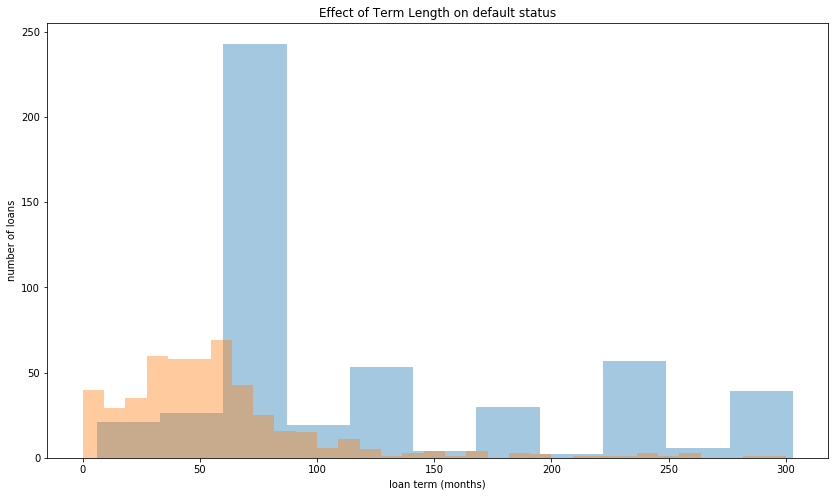

In [11]:
plt.figure(figsize = (14, 8))

plt.title("Effect of Term Length on default status")

sns.distplot(sampled.loc[sampled['MIS_Status'] == 'P I F', 'Term'], label = 'Paid', kde = False)
sns.distplot(sampled.loc[sampled['MIS_Status'] != 'P I F', 'Term'], label = "Default", kde = False)

plt.xlabel("loan term (months)")
plt.ylabel("number of loans")
plt.show()
plt.close()

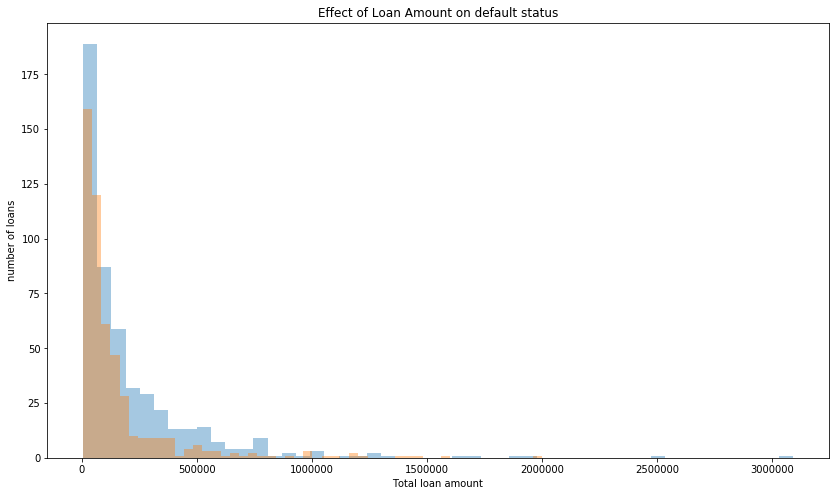

In [12]:
plt.figure(figsize = (14, 8))

plt.title("Effect of Loan Amount on default status")

sns.distplot(sampled.loc[sampled['MIS_Status'] == 'P I F', 'DisbursementGross'], label = 'Paid', kde = False)
sns.distplot(sampled.loc[sampled['MIS_Status'] != 'P I F', 'DisbursementGross'], label = "Default", kde = False)

plt.xlabel("Total loan amount")
plt.ylabel("number of loans")
plt.show()
plt.close()

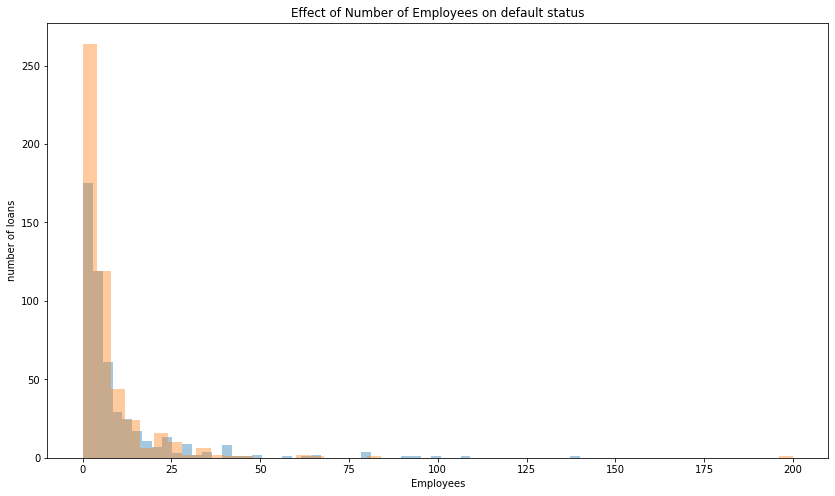

In [13]:
plt.figure(figsize = (14, 8))

plt.title("Effect of Number of Employees on default status")

sns.distplot(sampled.loc[sampled['MIS_Status'] == 'P I F', 'NoEmp'], label = 'Paid', kde = False)
sns.distplot(sampled.loc[sampled['MIS_Status'] != 'P I F', 'NoEmp'], label = "Default", kde = False)

plt.xlabel("Employees")
plt.ylabel("number of loans")
plt.show()
plt.close()

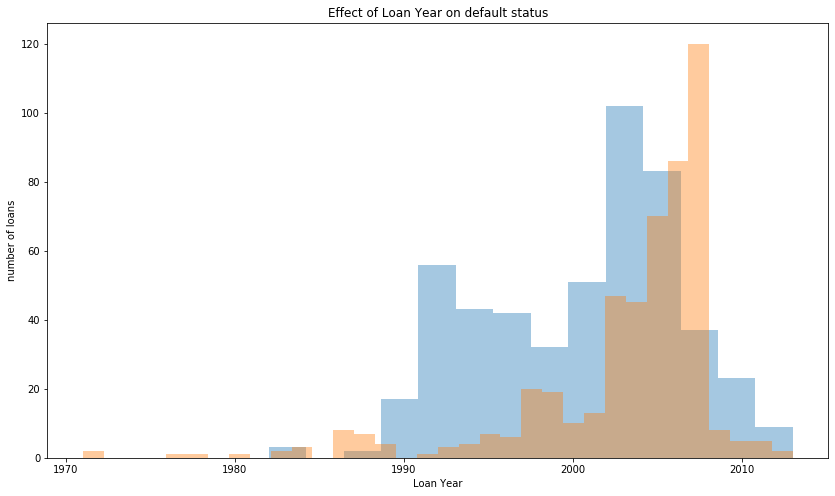

In [17]:
plt.figure(figsize = (14, 8))

plt.title("Effect of Loan Year on default status")

sns.distplot(sampled.loc[sampled['MIS_Status'] == 'P I F', 'Approval_Year'], label = 'Paid', kde = False)
sns.distplot(sampled.loc[sampled['MIS_Status'] != 'P I F', 'Approval_Year'], label = "Default", kde = False)

plt.xlabel("Loan Year")
plt.ylabel("number of loans")
plt.show()
plt.close()

Based on what I'm seeing so far in the graphs, defaults seem to be more likely with shorter loan terms and perhaps with smaller companies. They were also more common for loans originating in the 2000s than they were for loans originating earlier. I'm not seeing a lot of indication that loan amount makes a huge difference in default likelihood.

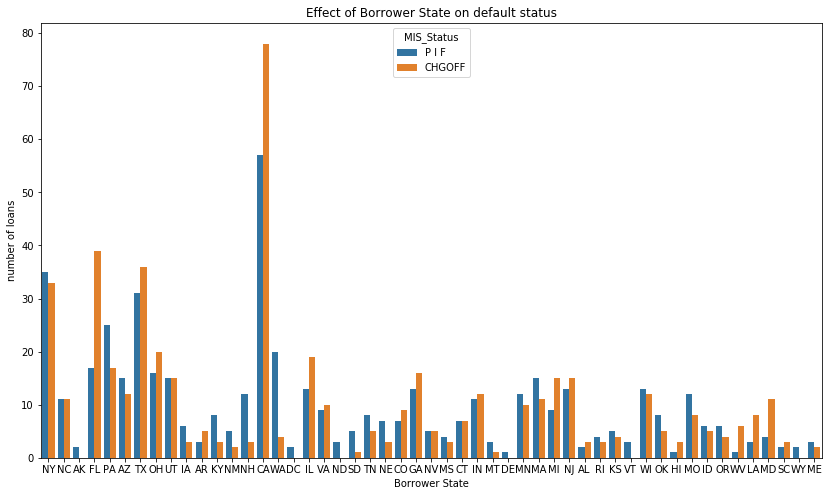

In [18]:
plt.figure(figsize = (14, 8))

plt.title("Effect of Borrower State on default status")

sns.countplot(x="State", hue="MIS_Status",  data=sampled)
plt.xlabel("Borrower State")
plt.ylabel("number of loans")
plt.show()
plt.close()

In [16]:
sampled.columns

Index(['Unnamed: 0', 'State', 'Bank', 'BankState', 'NAICS', 'Term', 'NoEmp',
       'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural',
       'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross',
       'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'Approval_Year',
       'Approval_Month', 'Approval_Day', 'Disbursement_Year',
       'Disbursement_Month', 'Disbursement_Day', 'Disbursement_Delay',
       'State_Match', 'Default_Delay', 'Bank_Size', 'ChgOff_Year',
       'ChgOff_Month', 'ChgOff_Day'],
      dtype='object')

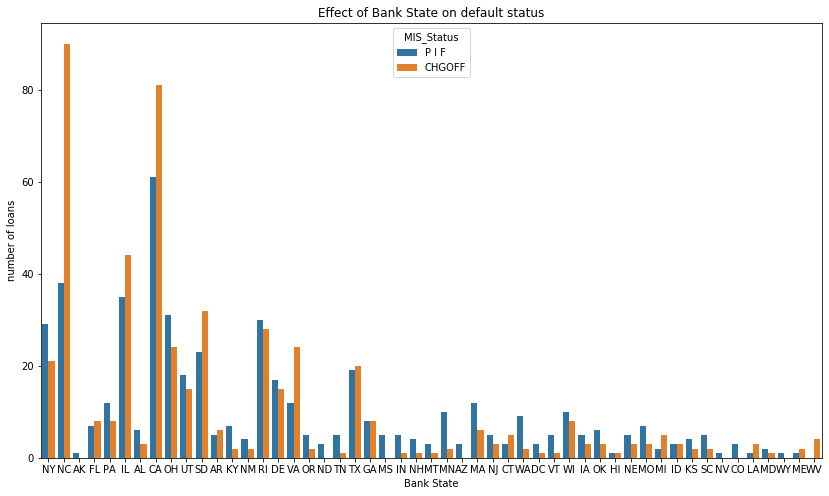

In [19]:
plt.figure(figsize = (14, 8))

plt.title("Effect of Bank State on default status")

sns.countplot(x="BankState", hue="MIS_Status",  data=sampled)
plt.xlabel("Bank State")
plt.ylabel("number of loans")
plt.show()
plt.close()

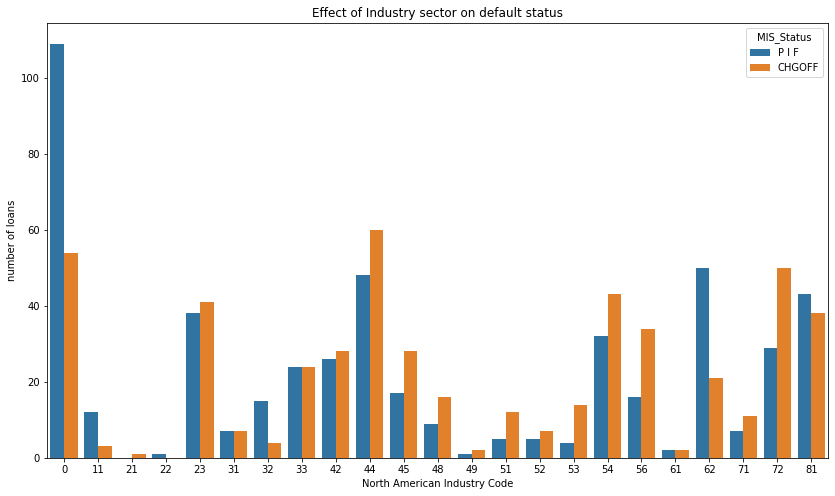

In [20]:
plt.figure(figsize = (14, 8))

plt.title("Effect of Industry sector on default status")

sns.countplot(x="NAICS", hue="MIS_Status",  data=sampled)
plt.xlabel("North American Industry Code")
plt.ylabel("number of loans")
plt.show()
plt.close()

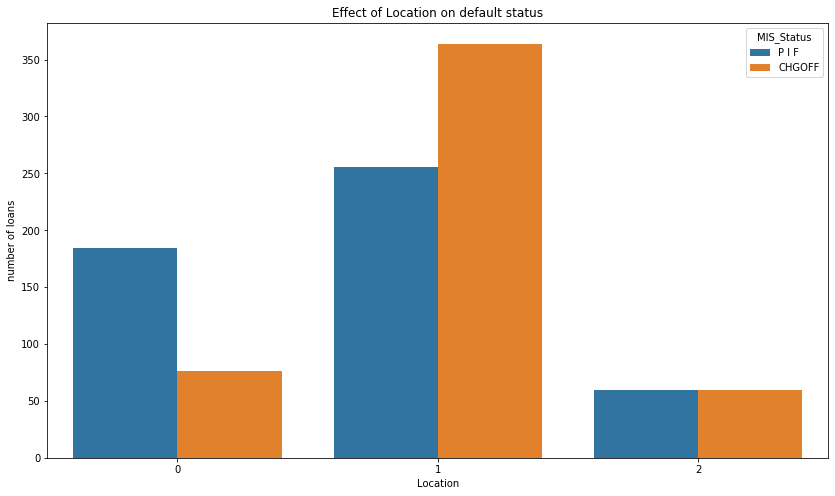

In [21]:

plt.figure(figsize = (14, 8))

plt.title("Effect of Location on default status")

sns.countplot(x="UrbanRural", hue="MIS_Status",  data=sampled)
plt.xlabel("Location")
plt.ylabel("number of loans")
plt.show()
plt.close()

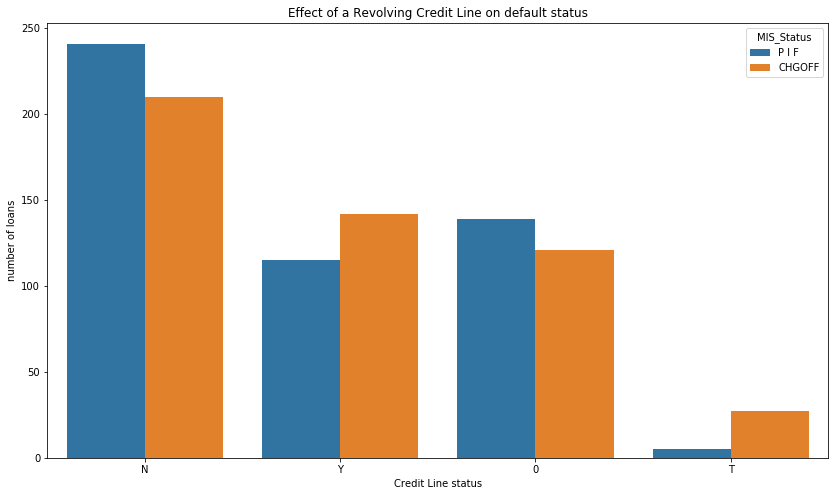

In [40]:

plt.figure(figsize = (14, 8))

plt.title("Effect of a Revolving Credit Line on default status")

sns.countplot(x="RevLineCr", hue="MIS_Status",  data=sampled)
plt.xlabel("Credit Line status")
plt.ylabel("number of loans")
plt.show()
plt.close()

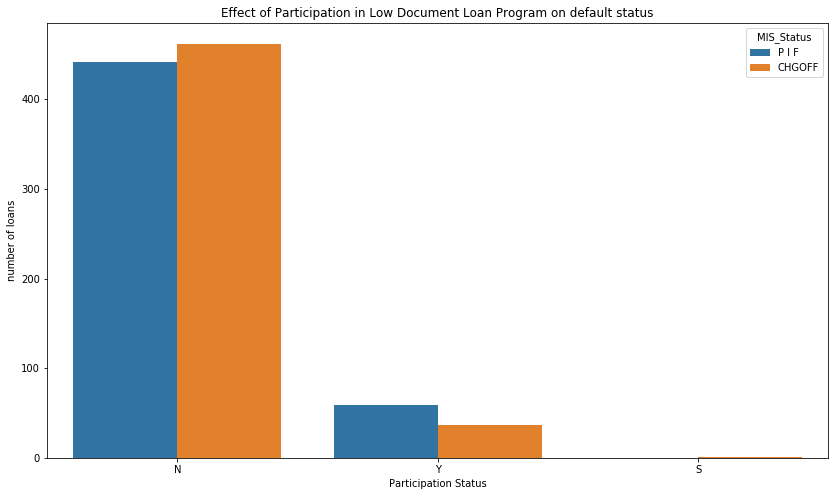

In [39]:

plt.figure(figsize = (14, 8))

plt.title("Effect of Participation in Low Document Loan Program on default status")

sns.countplot(x="LowDoc", hue="MIS_Status",  data=sampled)
plt.xlabel("Participation Status")
plt.ylabel("number of loans")
plt.show()
plt.close()

A rather cursory look at these graphs suggests that the most significant single variables may be:
1. ```RevLineCr```,
2. ```ApprovalFY```,
3. ```NAICS```,
4. ```Term```,
5. ```LoanAmount```, and
6. ```State``` (or ```BankState```)

Next, I want to examine relationships between pairs of variables, again colored by ```MIS_Status```.

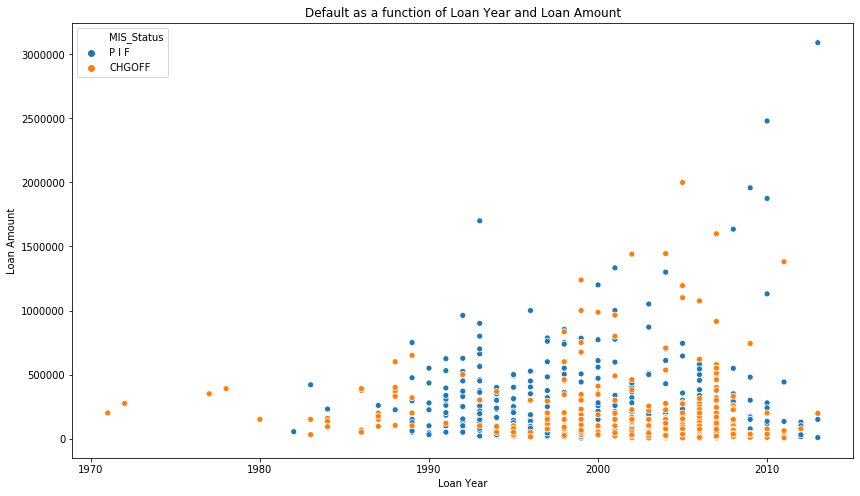

In [25]:

plt.figure(figsize = (14, 8))

plt.title("Default as a function of Loan Year and Loan Amount")

sns.scatterplot(x="Approval_Year", y = "DisbursementGross", hue="MIS_Status",  data=sampled)
plt.xlabel("Loan Year")
plt.ylabel("Loan Amount")
plt.show()
plt.close()

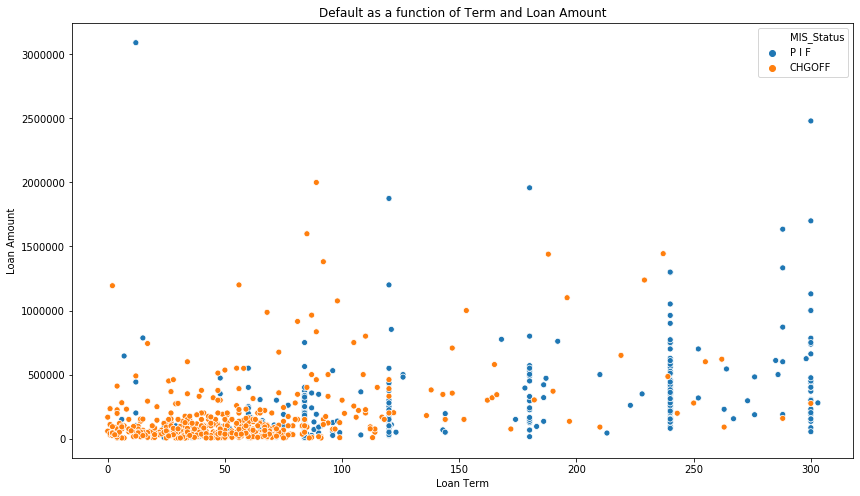

In [26]:

plt.figure(figsize = (14, 8))

plt.title("Default as a function of Term and Loan Amount")

sns.scatterplot(x="Term", y = "DisbursementGross", hue="MIS_Status",  data=sampled)
plt.xlabel("Loan Term (in months)")
plt.ylabel("Loan Amount (in dollars)")
plt.show()
plt.close()

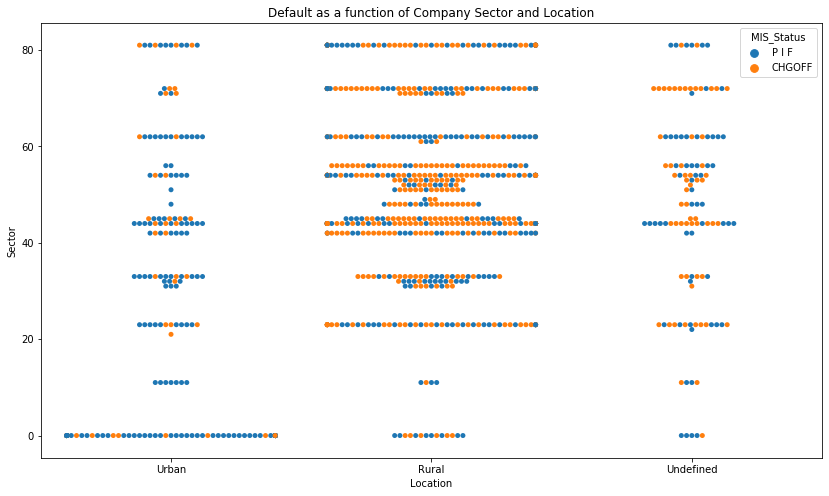

In [34]:

plt.figure(figsize = (14, 8))

plt.title("Default as a function of Company Sector and Location")

sns.swarmplot(x="UrbanRural", y = "NAICS", hue="MIS_Status",  data=sampled)
plt.xticks([0, 1, 2], ('Urban', 'Rural', 'Undefined'))
plt.xlabel("Location")
plt.ylabel("Sector")
plt.show()
plt.close()

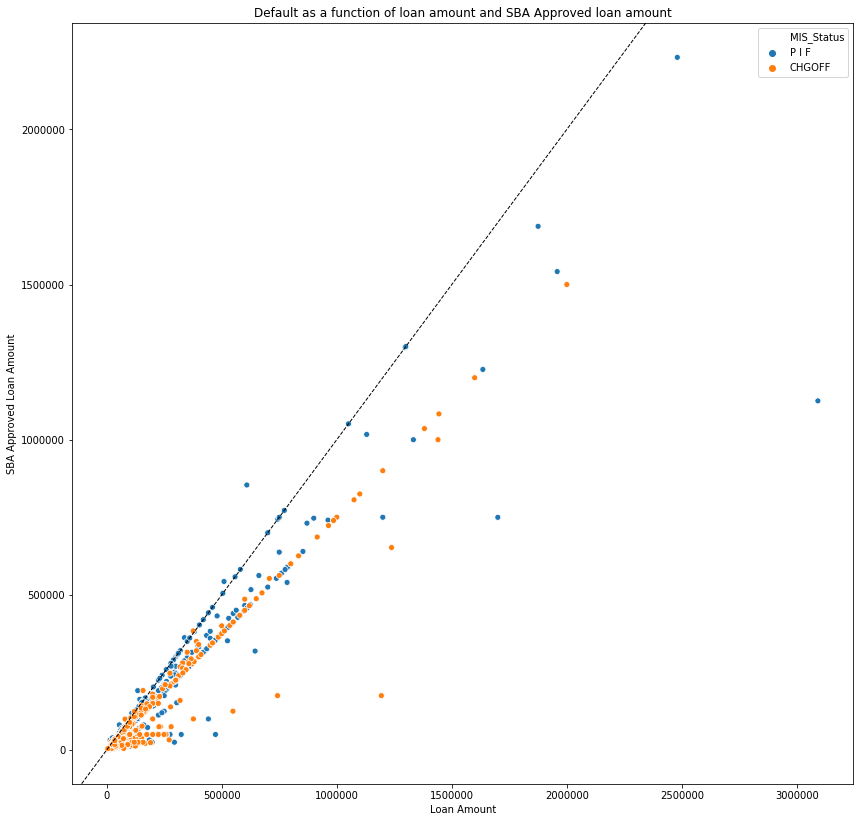

In [31]:

plt.figure(figsize = (14, 14))

plt.title("Default as a function of loan amount and SBA Approved loan amount")

sns.scatterplot(x="DisbursementGross", y = "SBA_Appv", hue="MIS_Status",  data=sampled)

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)

plt.xlabel("Loan Amount")
plt.ylabel("SBA Approved Loan Amount")
plt.show()
plt.close()

In [41]:
sampled.columns

Index(['Unnamed: 0', 'State', 'Bank', 'BankState', 'NAICS', 'Term', 'NoEmp',
       'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural',
       'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross',
       'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'Approval_Year',
       'Approval_Month', 'Approval_Day', 'Disbursement_Year',
       'Disbursement_Month', 'Disbursement_Day', 'Disbursement_Delay',
       'State_Match', 'Default_Delay', 'Bank_Size', 'ChgOff_Year',
       'ChgOff_Month', 'ChgOff_Day'],
      dtype='object')

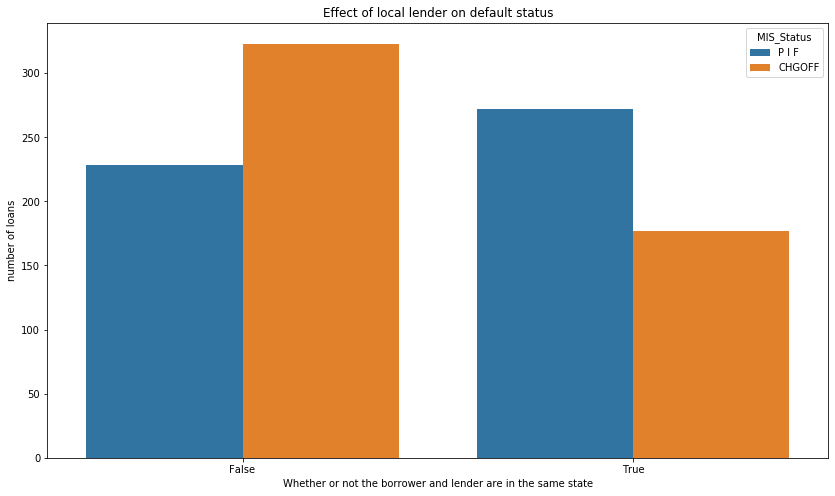

In [42]:

plt.figure(figsize = (14, 8))

plt.title("Effect of local lender on default status")

sns.countplot(x="State_Match", hue="MIS_Status",  data=sampled)
plt.xlabel("Whether or not the borrower and lender are in the same state")
plt.ylabel("number of loans")
plt.show()
plt.close()

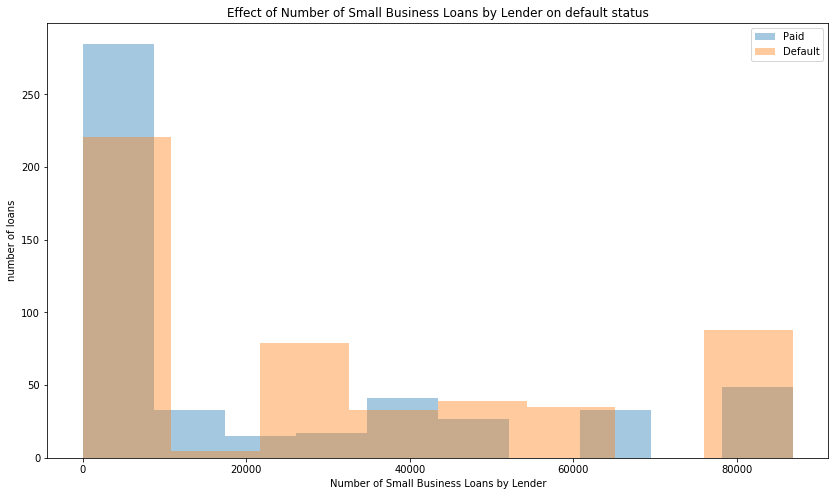

In [48]:
plt.figure(figsize = (14, 8))

plt.title("Effect of Number of Small Business Loans by Lender on default status")

sns.distplot(sampled.loc[sampled['MIS_Status'] == 'P I F', 'Bank_Size'], label = 'Paid', kde = False)
sns.distplot(sampled.loc[sampled['MIS_Status'] != 'P I F', 'Bank_Size'], label = "Default", kde = False)

plt.xlabel("Number of Small Business Loans by Lender")
plt.ylabel("number of loans")
plt.legend()
plt.show()
plt.close()

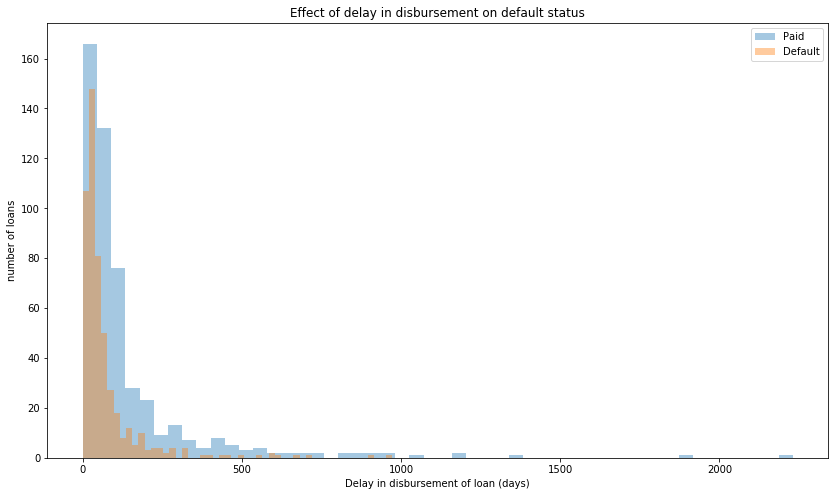

In [49]:
plt.figure(figsize = (14, 8))

plt.title("Effect of delay in disbursement on default status")

sns.distplot(sampled.loc[sampled['MIS_Status'] == 'P I F', 'Disbursement_Delay'], label = 'Paid', kde = False)
sns.distplot(sampled.loc[sampled['MIS_Status'] != 'P I F', 'Disbursement_Delay'], label = "Default", kde = False)

plt.xlabel("Delay in disbursement of loan (days)")
plt.ylabel("number of loans")
plt.legend()
plt.show()
plt.close()

In [60]:
is_franchise = [item not in [0,1] for item in sampled['FranchiseCode']]
sampled['is_franchise'] = is_franchise

In [61]:
sampled.head()

,Unnamed: 0,State,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,...,Disbursement_Month,Disbursement_Day,Disbursement_Delay,State_Match,Default_Delay,Bank_Size,ChgOff_Year,ChgOff_Month,ChgOff_Day,is_franchise
89193,90056,NY,MANUFACTURERS & TRADERS TR CO,NY,33,60,24,1.0,4,28,...,3.0,31.0,42.0,True,NaN,11265.0,NaN,NaN,NaN,False
340189,343538,NC,SURREY BANK & TRUST,NC,48,84,1,2.0,0,1,...,6.0,30.0,64.0,True,NaN,378.0,NaN,NaN,NaN,False
861200,873997,AK,DENALI STATE BANK,AK,0,180,9,1.0,0,0,...,6.0,30.0,327.0,True,NaN,80.0,NaN,NaN,NaN,False
822167,834866,FL,BANESCO USA,FL,44,84,8,1.0,0,0,...,4.0,30.0,97.0,True,NaN,74.0,NaN,NaN,NaN,False
136433,137568,PA,FULTON BANK NATL ASSOC,PA,45,83,4,2.0,0,0,...,10.0,31.0,922.0,True,NaN,469.0,NaN,NaN,NaN,False


In [67]:
sampled['real_estate'] = sampled['Term'] >= 240

In [70]:
sampled.columns.to_list()

['Unnamed: 0',
 'State',
 'Bank',
 'BankState',
 'NAICS',
 'Term',
 'NoEmp',
 'NewExist',
 'CreateJob',
 'RetainedJob',
 'FranchiseCode',
 'UrbanRural',
 'RevLineCr',
 'LowDoc',
 'DisbursementGross',
 'BalanceGross',
 'MIS_Status',
 'ChgOffPrinGr',
 'GrAppv',
 'SBA_Appv',
 'Approval_Year',
 'Approval_Month',
 'Approval_Day',
 'Disbursement_Year',
 'Disbursement_Month',
 'Disbursement_Day',
 'Disbursement_Delay',
 'State_Match',
 'Default_Delay',
 'Bank_Size',
 'ChgOff_Year',
 'ChgOff_Month',
 'ChgOff_Day',
 'is_franchise',
 'real_estate']

In [75]:

crap = sampled.loc[89193, 'Term'] + sampled.loc[89193, 'Disbursement_Month']

crap

63.0

In [77]:
crap % 12

3.0

In [78]:
crap // 12

5.0

In [118]:
sampled['pct_guaranteed'] = sampled['SBA_Appv']/sampled['DisbursementGross']

In [79]:
sampled['temp'] = sampled['Term'] + sampled['Disbursement_Month']

In [81]:
sampled['temp'] = sampled['Term'] + sampled['Disbursement_Month']
sampled['end_month'] = sampled['temp'] % 12
sampled['end_year'] = sampled['Disbursement_Year'] + sampled['temp']//12

In [83]:
sampled['end_year'] = sampled['Disbursement_Year'] + sampled['temp']//12
sampled.head()

,Unnamed: 0,State,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,...,Default_Delay,Bank_Size,ChgOff_Year,ChgOff_Month,ChgOff_Day,is_franchise,real_estate,temp,end_month,end_year
89193,90056,NY,MANUFACTURERS & TRADERS TR CO,NY,33,60,24,1.0,4,28,...,NaN,11265.0,NaN,NaN,NaN,False,False,63.0,3.0,2011.0
340189,343538,NC,SURREY BANK & TRUST,NC,48,84,1,2.0,0,1,...,NaN,378.0,NaN,NaN,NaN,False,False,90.0,6.0,2016.0
861200,873997,AK,DENALI STATE BANK,AK,0,180,9,1.0,0,0,...,NaN,80.0,NaN,NaN,NaN,False,False,186.0,6.0,2012.0
822167,834866,FL,BANESCO USA,FL,44,84,8,1.0,0,0,...,NaN,74.0,NaN,NaN,NaN,False,False,88.0,4.0,2003.0
136433,137568,PA,FULTON BANK NATL ASSOC,PA,45,83,4,2.0,0,0,...,NaN,469.0,NaN,NaN,NaN,False,False,93.0,9.0,2007.0


In [91]:
sba['Approval_Year'].min()

1970

In [98]:
year = 2009
month = 6

(year - 1970) * 12 + month

474

In [94]:
sampled['disb_my'] = (sampled['Disbursement_Year'] - 1970) * 12 + sampled['Disbursement_Month']

In [96]:
sampled['end_my'] = (sampled['end_year'] - 1970) * 12 + sampled['end_month']
sampled.head()

,Unnamed: 0,State,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,...,ChgOff_Month,ChgOff_Day,is_franchise,real_estate,temp,end_month,end_year,pct_guaranteed,disb_my,end_my
89193,90056,NY,MANUFACTURERS & TRADERS TR CO,NY,33,60,24,1.0,4,28,...,NaN,NaN,False,False,63.0,3.0,2011.0,2.000000,435.0,495.0
340189,343538,NC,SURREY BANK & TRUST,NC,48,84,1,2.0,0,1,...,NaN,NaN,False,False,90.0,6.0,2016.0,3.882353,474.0,558.0
861200,873997,AK,DENALI STATE BANK,AK,0,180,9,1.0,0,0,...,NaN,NaN,False,False,186.0,6.0,2012.0,1.333333,330.0,510.0
822167,834866,FL,BANESCO USA,FL,44,84,8,1.0,0,0,...,NaN,NaN,False,False,88.0,4.0,2003.0,0.803571,316.0,400.0
136433,137568,PA,FULTON BANK NATL ASSOC,PA,45,83,4,2.0,0,0,...,NaN,NaN,False,False,93.0,9.0,2007.0,1.250000,370.0,453.0


In [ ]:
# 456 to 474

In [109]:
sampled['is_recession'] = (sampled['disb_my'] > 474) | (sampled['end_my']<456)

In [106]:
sampled['temp1'] = sampled['disb_my'] > 474
sampled['temp2'] = sampled['end_my'] < 456

sampled['is_recession'] = sampled['temp1'] | sampled['temp2']

In [110]:
sampled['is_recession'].value_counts()

False    641
True     359
Name: is_recession, dtype: int64

In [111]:
sampled['disb_my'] = ((sampled['Disbursement_Year'] - 1970) * 12
                        + sampled['Disbursement_Month'])

sampled['end_my'] = (sampled['end_year'] - 1970) * 12 + sampled['end_month']


sampled['is_recession'] = (sampled['disb_my'] > 474) | (sampled['end_my'] < 456)

And now let's take a look at the graphs for the new variables that we've added...

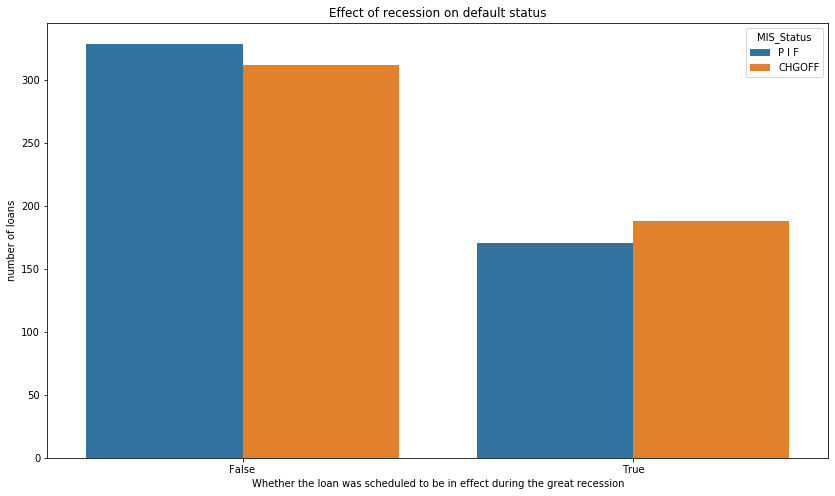

In [117]:

plt.figure(figsize = (14, 8))

plt.title("Effect of recession on default status")

sns.countplot(x="is_recession", hue="MIS_Status",  data=sampled)
plt.xlabel("Whether the loan was scheduled to be in effect during the great recession")
plt.ylabel("number of loans")
plt.show()
plt.close()

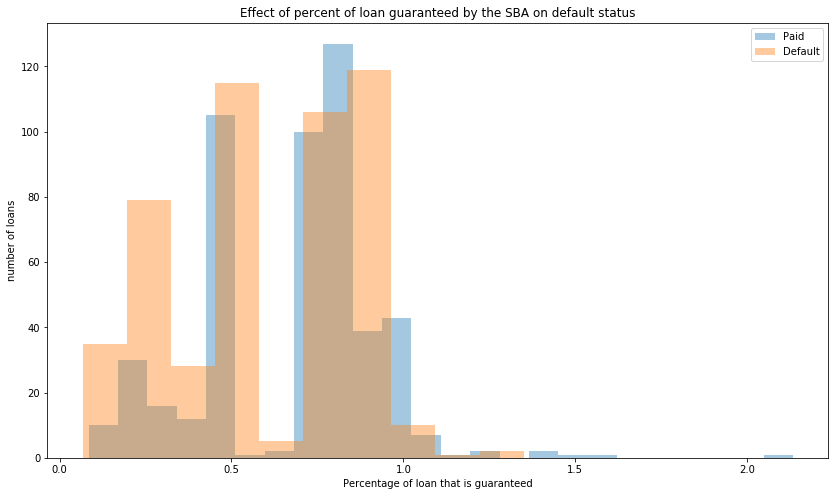

In [121]:
plt.figure(figsize = (14, 8))

plt.title("Effect of percent of loan guaranteed by the SBA on default status")

sns.distplot(sampled.loc[sampled['MIS_Status'] == 'P I F', 'pct_guaranteed'], label = 'Paid', kde = False)
sns.distplot(sampled.loc[sampled['MIS_Status'] != 'P I F', 'pct_guaranteed'], label = "Default", kde = False)

plt.xlabel("Percentage of loan that is guaranteed")
plt.ylabel("number of loans")
plt.legend()
plt.show()
plt.close()

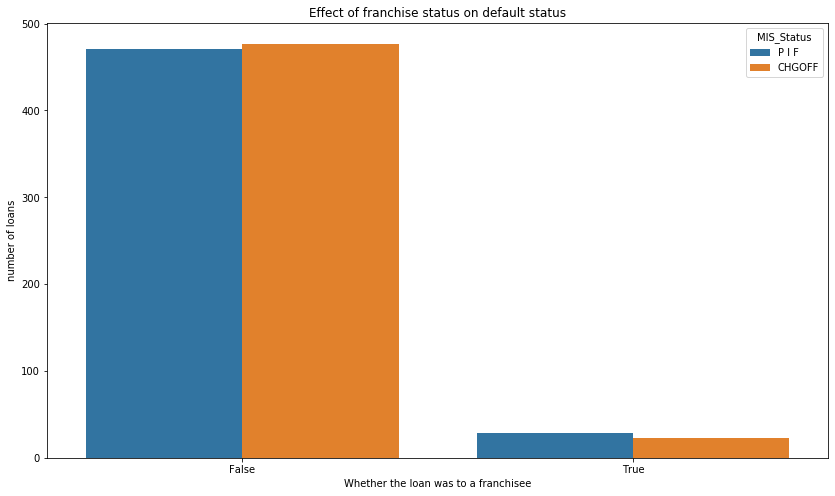

In [122]:

plt.figure(figsize = (14, 8))

plt.title("Effect of franchise status on default status")

sns.countplot(x="is_franchise", hue="MIS_Status",  data=sampled)
plt.xlabel("Whether the loan was to a franchisee")
plt.ylabel("number of loans")
plt.show()
plt.close()

OK, so, the next thing that I need to do is to split my data into training, validation, and test sets. Given the amount of data that I have (886282), I'm going to start here by working with a random 10% of my data, which I will then split into 80-10-10 for this.

In [133]:
for column in sba.columns.tolist():
    print("The current column is : ", column)
    print(sba[column].value_counts())

The current column is :  Unnamed: 0
2047      1
180493    1
157976    1
135447    1
137494    1
         ..
349696    1
699391    1
697342    1
703485    1
0         1
Name: Unnamed: 0, Length: 886282, dtype: int64
The current column is :  State
CA    129404
TX     69350
NY     56874
FL     40673
PA     34399
OH     32202
IL     29151
MA     24742
MN     24130
NJ     23817
WA     22972
GA     21998
WI     20758
MO     20414
CO     20342
MI     20282
UT     18612
AZ     17431
NC     14065
IN     13883
MD     13063
VA     12929
CT     12001
NH     11871
IA     11768
KS     11308
OR     10934
OK      9798
LA      9422
ID      9251
TN      9237
RI      8852
MT      8604
AL      8248
NV      7925
KY      7619
MS      7556
NE      6288
AR      6233
NM      5935
ME      5858
SC      5504
VT      5363
ND      5186
SD      4349
HI      3546
WV      3226
WY      2789
AK      2360
DE      2161
DC      1599
Name: State, dtype: int64
The current column is :  Bank
BANK OF AMERICA NATL ASSOC        8

True     468000
False    418282
Name: State_Match, dtype: int64
The current column is :  Default_Delay
1317.0    131
1316.0    127
1078.0    126
966.0     124
1286.0    124
         ... 
24.0        1
3890.0      1
7455.0      1
7675.0      1
4581.0      1
Name: Default_Delay, Length: 5556, dtype: int64
The current column is :  Bank_Size
86853.0    86077
63503.0    62936
48167.0    47461
35143.0    34752
35054.0    33569
           ...  
149.0        148
131.0        130
130.0        130
132.0        124
118.0        117
Name: Bank_Size, Length: 541, dtype: int64
The current column is :  ChgOff_Year
2010.0    34643
2009.0    19877
2011.0    19809
2008.0    18913
2006.0    11457
2012.0    10786
2013.0     8112
2007.0     7507
2014.0     5489
2005.0     3139
2003.0     3113
2002.0     2872
2001.0     2515
1991.0     2184
2004.0     2052
1990.0     1552
1989.0     1443
1992.0      760
1993.0      627
1997.0      619
1999.0      598
1998.0      553
2000.0      522
1996.0      506
1994.0   

OK, so now looking at what I have (see above) it's relatively clear that there's at least some garbage here. The next step is going to be to get rid of those rows, and to see what we're left with. For the most part, I'm just going to eliminate the rows with garbage data, but I'll have to see what exactly I'm left with under those circumstances. In particular I'm worried about the "UrbanRural" column, which has a significant number of entries (~40%) that are 0, which correlates to neither urban nor rural, but which may, I suppose, correlate with suburban or with unknown. In any case, I'm a bit reluctant to dump that much data. In fact, having a value of 0 seems to correspond quite strongly with paying off the loan, so it's probably best to keep it...

In [149]:
sba_cleaned = sba.copy()

In [150]:
len(sba_cleaned)

886282

In [151]:
sba_cleaned = sba_cleaned.loc[(sba_cleaned['BankState'] != 'AN') & (sba_cleaned['BankState'] != 'EN')]
len(sba_cleaned)

886280

In [152]:
sba_cleaned = sba_cleaned.loc[(sba_cleaned['NewExist'] != 0)]
len(sba_cleaned)

885259

In [153]:
sba_cleaned = sba_cleaned.loc[(sba_cleaned['RevLineCr'] == 'Y') | (sba_cleaned['RevLineCr'] == 'N') | (sba_cleaned['RevLineCr'] == '0')]
len(sba_cleaned)

870094

In [154]:
sba_cleaned = sba_cleaned.loc[(sba_cleaned['LowDoc'] == 'N') | (sba_cleaned['LowDoc'] == 'Y')]
len(sba_cleaned)

866951

In [157]:
sba_cleaned = sba_cleaned.loc[(sba_cleaned['Approval_Year'] != "2068") & (sba_cleaned['BankState'] != "2069")]
len(sba_cleaned)

866951

In [159]:
sba_cleaned = sba_cleaned.loc[(sba_cleaned['Disbursement_Year'] != 2068) & 
                              (sba_cleaned['Disbursement_Year'] != 2069) &
                              (sba_cleaned['Disbursement_Year'] != 2028) & 
                              (sba_cleaned['Disbursement_Year'] != 2020) &
                              (sba_cleaned['Disbursement_Year'] != 2048)]
len(sba_cleaned)

866946

In [162]:
sba_cleaned = sba_cleaned.loc[(sba_cleaned['Disbursement_Delay'] >= 0) & (sba_cleaned['Disbursement_Delay'] <= 1825)]
len(sba_cleaned)

865150

In [164]:
sba_cleaned = sba_cleaned.loc[(sba_cleaned['ChgOff_Year'] != 2026)]
len(sba_cleaned)

865149

In [165]:
sba_cleaned.to_csv('sba_cleaned.csv')

And now, finally, the split and the model...

# Tomorrow's start position

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, RobustScaler

sba_cleaned = pd.read_csv("sba_cleaned.csv")

In [3]:
sba_cleaned.reset_index(inplace = True, drop = True)

OK, and now there's something that I need to think kind of hard about here. Because this is time dependant data, I oughtn't use data on loans that originated in 2010 to determine whether or not a loan should have been made in 1985. On the other hand, if I consider only loans with an end date before the application/approval date for a given loan, then I'm going to end up discounting longer loan terms, which might be ok if they're looking for a 24 month loan, but which might be problematic if they're looking for a 20 year loan. 

One possibility is to add a third category to the possible status, so that I'd have at any given point loans that were paid in full, loans that were charged off, and loans that were in good standing. I suppose that I could add a fourth category, not yet approved to that. And I could even do that for January 1st of every year of data that I had. Then I could use all the data from loans that had been originated previous to that year in order to predict what was likely to happen...

In [5]:
sba_cleaned.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 'columns', inplace = True)
sba_cleaned.head()

,State,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,...,ChgOff_Day,is_franchise,real_estate,pct_guaranteed,disb_my,temp,end_month,end_year,end_my,is_recession
0,IN,FIFTH THIRD BANK,OH,45,84,4,2.0,0,0,1,...,NaN,False,False,0.80,350.0,86.0,2.0,2006.0,434.0,True
1,IN,1ST SOURCE BANK,IN,72,60,2,2.0,0,0,1,...,NaN,False,False,0.80,329.0,65.0,5.0,2002.0,389.0,True
2,IN,GRANT COUNTY STATE BANK,IN,62,180,7,1.0,0,0,1,...,NaN,False,False,0.75,336.0,192.0,0.0,2013.0,516.0,False
3,OK,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,1.0,0,0,1,...,NaN,False,False,0.80,330.0,66.0,6.0,2002.0,390.0,True
4,FL,FLORIDA BUS. DEVEL CORP,FL,0,240,14,1.0,7,7,1,...,NaN,False,True,1.00,329.0,245.0,5.0,2017.0,569.0,False


In [6]:
pd.options.display.max_columns = 50

sba_cleaned.head()

,State,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Approval_Year,Approval_Month,Approval_Day,Disbursement_Year,Disbursement_Month,Disbursement_Day,Disbursement_Delay,State_Match,Default_Delay,Bank_Size,ChgOff_Year,ChgOff_Month,ChgOff_Day,is_franchise,real_estate,pct_guaranteed,disb_my,temp,end_month,end_year,end_my,is_recession
0,IN,FIFTH THIRD BANK,OH,45,84,4,2.0,0,0,1,0,N,Y,60000.0,0.0,P I F,0.0,60000.0,48000.0,1997,2,28,1999.0,2.0,28.0,730.0,False,NaN,5216.0,NaN,NaN,NaN,False,False,0.80,350.0,86.0,2.0,2006.0,434.0,True
1,IN,1ST SOURCE BANK,IN,72,60,2,2.0,0,0,1,0,N,Y,40000.0,0.0,P I F,0.0,40000.0,32000.0,1997,2,28,1997.0,5.0,31.0,92.0,True,NaN,800.0,NaN,NaN,NaN,False,False,0.80,329.0,65.0,5.0,2002.0,389.0,True
2,IN,GRANT COUNTY STATE BANK,IN,62,180,7,1.0,0,0,1,0,N,N,287000.0,0.0,P I F,0.0,287000.0,215250.0,1997,2,28,1997.0,12.0,31.0,306.0,True,NaN,6.0,NaN,NaN,NaN,False,False,0.75,336.0,192.0,0.0,2013.0,516.0,False
3,OK,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,1.0,0,0,1,0,N,Y,35000.0,0.0,P I F,0.0,35000.0,28000.0,1997,2,28,1997.0,6.0,30.0,122.0,True,NaN,54.0,NaN,NaN,NaN,False,False,0.80,330.0,66.0,6.0,2002.0,390.0,True
4,FL,FLORIDA BUS. DEVEL CORP,FL,0,240,14,1.0,7,7,1,0,N,N,229000.0,0.0,P I F,0.0,229000.0,229000.0,1997,2,28,1997.0,5.0,14.0,75.0,True,NaN,1805.0,NaN,NaN,NaN,False,True,1.00,329.0,245.0,5.0,2017.0,569.0,False


In [8]:
toy = sba_cleaned.sample(100)
toy.reset_index(inplace = True, drop = True)
toy.head()

,State,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Approval_Year,Approval_Month,Approval_Day,Disbursement_Year,Disbursement_Month,Disbursement_Day,Disbursement_Delay,State_Match,Default_Delay,Bank_Size,ChgOff_Year,ChgOff_Month,ChgOff_Day,is_franchise,real_estate,pct_guaranteed,disb_my,temp,end_month,end_year,end_my,is_recession
0,TX,BANK OF AMERICA NATL ASSOC,NC,52,84,10,1.0,0,10,0,1,Y,N,58804.0,0.0,P I F,0.0,30000.0,15000.0,2005,8,26,2005.0,8.0,31.0,5.0,False,NaN,86853.0,NaN,NaN,NaN,False,False,0.255085,428.0,92.0,8.0,2012.0,512.0,False
1,MA,BERKSHIRE BANK,MA,72,54,8,1.0,0,0,1,2,0,Y,70000.0,0.0,CHGOFF,32236.0,70000.0,59500.0,2002,3,18,2002.0,5.0,31.0,74.0,True,1831.0,664.0,2007.0,6.0,5.0,False,False,0.850000,389.0,59.0,11.0,2006.0,443.0,True
2,MT,MOUNTAIN W. BANK NATL ASSOC,MT,44,6,4,2.0,0,0,1,0,N,N,25000.0,0.0,P I F,0.0,25000.0,20000.0,1998,12,2,2000.0,9.0,30.0,668.0,True,NaN,702.0,NaN,NaN,NaN,False,False,0.800000,369.0,15.0,3.0,2001.0,375.0,True
3,CA,BBCN BANK,CA,62,43,1,1.0,1,1,1,1,0,N,5000.0,0.0,CHGOFF,3696.0,5000.0,4250.0,2004,9,14,2004.0,9.0,30.0,16.0,True,1260.0,22978.0,2008.0,3.0,13.0,False,False,0.850000,417.0,52.0,4.0,2008.0,460.0,False
4,OH,CAPITAL ONE NATL ASSOC,VA,44,64,7,1.0,0,7,0,1,N,N,75000.0,0.0,CHGOFF,66971.0,75000.0,37500.0,2007,6,23,2007.0,7.0,31.0,38.0,False,767.0,22248.0,2009.0,9.0,5.0,False,False,0.500000,451.0,71.0,11.0,2012.0,515.0,False


In [63]:
def new_year_status(df, row):
    
    dyear = df.loc[row, 'Disbursement_Year']
    coyear = df.loc[row, 'ChgOff_Year']
    end = min(2014, df.loc[row, 'end_year'])
    
    #print(dyear, coyear, end)
    
    years = list(range(1970, 2015))
    status = [0 for year in years]
    
    first = years.index(dyear)
    
    if str(coyear) != 'nan':
        second = years.index(coyear)
    else:
        second = None
        
    final = years.index(end)
    
    #print(first, second, final)
    
    status[:first] = ['NoLoan'] * (first - 0)
    if second:
        status[first:second] = ['Good'] * (second - first)
        status[second:] = ['Default'] * (45 - second)
    else:
        #print(final-first)
        status[first:final] = ['Good'] * (final - first)
        status[final:] = ['Paid'] * (45 - final)
    
    
    return status

In [64]:
new_year_status(toy, 0)

['NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'NoLoan',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Paid',
 'Paid',
 'Paid']

In [70]:
%%timeit

statuses = []

for k in range(len(toy)):
    statuses.append(new_year_status(toy, k))

11.3 ms ± 68.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [69]:
pd.DataFrame(statuses)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
0,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Good,Good,Paid,Paid,Paid
1,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Default,Default,Default,Default,Default,Default,Default,Default
2,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid
3,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Default,Default,Default,Default,Default,Default,Default
4,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Default,Default,Default,Default,Default,Default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid
96,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Paid,Paid
97,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Paid
98,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Default


In [71]:
all_statuses = []

for k in range(len(sba_cleaned)):
    all_statuses.append(new_year_status(sba_cleaned, k))

In [72]:
years = list(range(1970,2015))
len(years)

45

In [75]:
cols = []

for year in years:
    cols.append(str(year) + '_status')
    

In [76]:
all_statuses = pd.DataFrame(all_statuses, columns = cols)

In [79]:
statuses = pd.DataFrame(statuses, columns = cols)

pd.concat([toy, statuses], axis = 1)

,State,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Approval_Year,Approval_Month,Approval_Day,Disbursement_Year,Disbursement_Month,Disbursement_Day,...,1990_status,1991_status,1992_status,1993_status,1994_status,1995_status,1996_status,1997_status,1998_status,1999_status,2000_status,2001_status,2002_status,2003_status,2004_status,2005_status,2006_status,2007_status,2008_status,2009_status,2010_status,2011_status,2012_status,2013_status,2014_status
0,TX,BANK OF AMERICA NATL ASSOC,NC,52,84,10,1.0,0,10,0,1,Y,N,58804.0,0.0,P I F,0.0,30000.0,15000.0,2005,8,26,2005.0,8.0,31.0,...,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Good,Good,Paid,Paid,Paid
1,MA,BERKSHIRE BANK,MA,72,54,8,1.0,0,0,1,2,0,Y,70000.0,0.0,CHGOFF,32236.0,70000.0,59500.0,2002,3,18,2002.0,5.0,31.0,...,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Default,Default,Default,Default,Default,Default,Default,Default
2,MT,MOUNTAIN W. BANK NATL ASSOC,MT,44,6,4,2.0,0,0,1,0,N,N,25000.0,0.0,P I F,0.0,25000.0,20000.0,1998,12,2,2000.0,9.0,30.0,...,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid
3,CA,BBCN BANK,CA,62,43,1,1.0,1,1,1,1,0,N,5000.0,0.0,CHGOFF,3696.0,5000.0,4250.0,2004,9,14,2004.0,9.0,30.0,...,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Default,Default,Default,Default,Default,Default,Default
4,OH,CAPITAL ONE NATL ASSOC,VA,44,64,7,1.0,0,7,0,1,N,N,75000.0,0.0,CHGOFF,66971.0,75000.0,37500.0,2007,6,23,2007.0,7.0,31.0,...,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Default,Default,Default,Default,Default,Default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,PA,MANUFACTURERS & TRADERS TR CO,NY,33,12,6,1.0,0,0,1,0,N,N,40000.0,0.0,P I F,0.0,40000.0,30000.0,1993,11,9,1994.0,4.0,30.0,...,NoLoan,NoLoan,NoLoan,NoLoan,Good,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid
96,CA,CDC SMALL BUS. FINAN CORP,CA,0,240,35,1.0,12,23,1,0,N,N,287000.0,0.0,P I F,0.0,288000.0,288000.0,1993,3,30,1993.0,7.0,14.0,...,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Paid,Paid
97,TN,REGIONS BANK,AL,42,240,2,2.0,0,0,1,0,N,N,442000.0,0.0,P I F,0.0,471000.0,353250.0,1994,2,4,1994.0,7.0,31.0,...,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Paid
98,CA,BENEFICIAL STATE BANK,CA,44,72,1,2.0,3,1,0,1,N,N,900000.0,0.0,CHGOFF,649456.0,900000.0,810000.0,2009,9,5,2010.0,2.0,1.0,...,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Default


In [80]:
sba_data = pd.concat([sba_cleaned, all_statuses], axis = 1)
sba_data.head()

,State,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Approval_Year,Approval_Month,Approval_Day,Disbursement_Year,Disbursement_Month,Disbursement_Day,...,1990_status,1991_status,1992_status,1993_status,1994_status,1995_status,1996_status,1997_status,1998_status,1999_status,2000_status,2001_status,2002_status,2003_status,2004_status,2005_status,2006_status,2007_status,2008_status,2009_status,2010_status,2011_status,2012_status,2013_status,2014_status
0,IN,FIFTH THIRD BANK,OH,45,84,4,2.0,0,0,1,0,N,Y,60000.0,0.0,P I F,0.0,60000.0,48000.0,1997,2,28,1999.0,2.0,28.0,...,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Good,Good,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid
1,IN,1ST SOURCE BANK,IN,72,60,2,2.0,0,0,1,0,N,Y,40000.0,0.0,P I F,0.0,40000.0,32000.0,1997,2,28,1997.0,5.0,31.0,...,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid
2,IN,GRANT COUNTY STATE BANK,IN,62,180,7,1.0,0,0,1,0,N,N,287000.0,0.0,P I F,0.0,287000.0,215250.0,1997,2,28,1997.0,12.0,31.0,...,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Paid,Paid
3,OK,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,1.0,0,0,1,0,N,Y,35000.0,0.0,P I F,0.0,35000.0,28000.0,1997,2,28,1997.0,6.0,30.0,...,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid
4,FL,FLORIDA BUS. DEVEL CORP,FL,0,240,14,1.0,7,7,1,0,N,N,229000.0,0.0,P I F,0.0,229000.0,229000.0,1997,2,28,1997.0,5.0,14.0,...,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Paid


OK, and now I think that I should be able to split this in a useful way, I hope

So, looking at 2005 as the end of the training data, and 2007 or 2008 as the end of the validation data. So I want something like this:


In [97]:
train = sba_data.loc[sba_data['Disbursement_Year'] <= 2005].index.tolist()
test = sba_data.loc[sba_data['Disbursement_Year'] >= 2008].index.tolist()

valid = set(sba_data.index.tolist()) ^ (set(train) | set(test))

print('There are ', len(train), ' training observations.')
print('There are ', len(valid), ' validation observations.')
print('There are ', len(test), ' test observations.')

There are  633487  training observations.
There are  142468  validation observations.
There are  89194  test observations.


And now I'd like to check whether these groups are semi well balanced...

In [98]:
sba_data.loc[train, 'MIS_Status'].value_counts()

P I F     558242
CHGOFF     75245
Name: MIS_Status, dtype: int64

In [99]:
sba_data.loc[valid, 'MIS_Status'].value_counts()

P I F     87221
CHGOFF    55247
Name: MIS_Status, dtype: int64

In [100]:
sba_data.loc[test, 'MIS_Status'].value_counts()

P I F     70900
CHGOFF    18294
Name: MIS_Status, dtype: int64

In [105]:
sba_data['MIS_Status'].value_counts()

P I F     716363
CHGOFF    148786
Name: MIS_Status, dtype: int64

Hmm, so what I'm seeing here is that these fractions are very much off with the splits as I have them. At the moment, I have

|   |  Paid In Full | Charged Off |
|---|--------------:|------------:|
|Train|88.12% | 11.88%|
|Validation|61.22%|38.78%|
|Test|79.49%|20.51%|
|Overall|82.80%|17.20%|

In other words, there is a significant difference between the distributions of the three subgroups. A suggested approach is to shrink the size of the validation set by adding data from 2006 to the training set, and possibly moving data from 2008 back to the validation set, in order to avoid having the validation set be a single year.

One observation (which is fairly obvious) is that we're dealing with a recession in 2007-2008, which is likely to throw of the balance of these divisions no matter what I do, so long as I want to perform these splits chronologically (and I do, if possible).

In [106]:
a = 716363+148786
716363/a, 148786/a

(0.8280226874214731, 0.17197731257852694)

In [113]:
train = sba_data.loc[sba_data['Disbursement_Year'] <= 2007].index.tolist()
test = sba_data.loc[sba_data['Disbursement_Year'] >= 2010].index.tolist()

valid = set(sba_data.index.tolist()) ^ (set(train) | set(test))

print('There are ', len(train), ' training observations.')
print('There are ', len(valid), ' validation observations.')
print('There are ', len(test), ' test observations.')

There are  775955  training observations.
There are  55324  validation observations.
There are  33870  test observations.


In [114]:
sba_data.loc[train, 'MIS_Status'].value_counts()

P I F     645463
CHGOFF    130492
Name: MIS_Status, dtype: int64

In [115]:
sba_data.loc[valid, 'MIS_Status'].value_counts()

P I F     39839
CHGOFF    15485
Name: MIS_Status, dtype: int64

In [116]:
sba_data.loc[test, 'MIS_Status'].value_counts()

P I F     31061
CHGOFF     2809
Name: MIS_Status, dtype: int64

In [117]:
sba_data['MIS_Status'].value_counts()

P I F     716363
CHGOFF    148786
Name: MIS_Status, dtype: int64

This is somewhat better. The test set is still somewhat off, but I'm less concerned (somehow) with that than I am with the validation set. 

|   |  Paid In Full | Charged Off |
|---|--------------:|------------:|
|Train|83.18% | 16.82%|
|Validation|72.01%|27.99%|
|Test|91.70%|8.29%|
|Overall|82.80%|17.20%|

I think that one issue here is still probably the effect of the regression ...

I'm still a bit concerned about how I'm going to make this come out the way that I want it to, to be completely honest. I kmnow that I need to divide my data into training, validation, and testing sets. I also know that I'm dealing with data where, for example, when I'm making a decision about whether or not a loan should be made in 2010, I can't possibly have any data about loans made after 2010. And where I'll have limited data about at least some loans made before 2010, since they will have neither gone into arrears nor been paid off yet. 

What I want to be able to do is something like this: Use the loans that originated in 1970 to predict whether or not I want to make the loans requested in 1971. Then, use the loans that originated in 1970 and 1971 to predict the loans requested in 1972. Continue in this fashion until, say 2000 to begin with, and see what's happening with the coefficients, and how the accuracy of the predictions changes. In other words, try to perform a cross validation that is time dependant.

To begin with, I'm going to include most of the variables, I think...

In [121]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline

In [132]:
def loan_predict(df, year):
    
    train_index = df.loc[df['Disbursement_Year'] < year].index.tolist()
    test_index = df.loc[df['Disbursement_Year'] == year].index.tolist()
    
    y_train = df.loc[train_index, 'MIS_Status']
    y_test = df.loc[test_index, 'MIS_Status']
    
    cols = ['State', 'BankState', 'NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
            'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementGross', 'GrAppv', 'SBA_Appv', 'Approval_Year', 
            'Approval_Month', 'Approval_Day', 'State_Match', 'is_franchise', 'real_estate', 'pct_guaranteed']
    cols.append(str(year) + '_status')
    
    to_encode = ['State', 'BankState', 'NAICS', 'UrbanRural']
    to_binarize = ['LowDoc', 'RevLineCr', 'State_Match', 'is_franchise', 'real_estate', 'NewExist']
    to_normalize = ['Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross', 'GrAppv', 'SBA_Appv',
                    'Approval_Year']
    
    return df.loc[:, [cols]].head()

In [135]:
pd.options.display.max_columns = 100

sba_data.head()

,State,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Approval_Year,Approval_Month,Approval_Day,Disbursement_Year,Disbursement_Month,Disbursement_Day,Disbursement_Delay,State_Match,Default_Delay,Bank_Size,ChgOff_Year,ChgOff_Month,ChgOff_Day,is_franchise,real_estate,pct_guaranteed,disb_my,temp,end_month,end_year,end_my,is_recession,1970_status,1971_status,1972_status,1973_status,1974_status,1975_status,1976_status,1977_status,1978_status,1979_status,1980_status,1981_status,1982_status,1983_status,1984_status,1985_status,1986_status,1987_status,1988_status,1989_status,1990_status,1991_status,1992_status,1993_status,1994_status,1995_status,1996_status,1997_status,1998_status,1999_status,2000_status,2001_status,2002_status,2003_status,2004_status,2005_status,2006_status,2007_status,2008_status,2009_status,2010_status,2011_status,2012_status,2013_status,2014_status
0,IN,FIFTH THIRD BANK,OH,45,84,4,2.0,0,0,1,0,N,Y,60000.0,0.0,P I F,0.0,60000.0,48000.0,1997,2,28,1999.0,2.0,28.0,730.0,False,NaN,5216.0,NaN,NaN,NaN,False,False,0.80,350.0,86.0,2.0,2006.0,434.0,True,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Good,Good,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid
1,IN,1ST SOURCE BANK,IN,72,60,2,2.0,0,0,1,0,N,Y,40000.0,0.0,P I F,0.0,40000.0,32000.0,1997,2,28,1997.0,5.0,31.0,92.0,True,NaN,800.0,NaN,NaN,NaN,False,False,0.80,329.0,65.0,5.0,2002.0,389.0,True,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid
2,IN,GRANT COUNTY STATE BANK,IN,62,180,7,1.0,0,0,1,0,N,N,287000.0,0.0,P I F,0.0,287000.0,215250.0,1997,2,28,1997.0,12.0,31.0,306.0,True,NaN,6.0,NaN,NaN,NaN,False,False,0.75,336.0,192.0,0.0,2013.0,516.0,False,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Paid,Paid
3,OK,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,1.0,0,0,1,0,N,Y,35000.0,0.0,P I F,0.0,35000.0,28000.0,1997,2,28,1997.0,6.0,30.0,122.0,True,NaN,54.0,NaN,NaN,NaN,False,False,0.80,330.0,66.0,6.0,2002.0,390.0,True,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid,Paid
4,FL,FLORIDA BUS. DEVEL CORP,FL,0,240,14,1.0,7,7,1,0,N,N,229000.0,0.0,P I F,0.0,229000.0,229000.0,1997,2,28,1997.0,5.0,14.0,75.0,True,NaN,1805.0,NaN,NaN,NaN,False,True,1.00,329.0,245.0,5.0,2017.0,569.0,False,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,NoLoan,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Good,Paid


In [127]:
['State', 'Bank', 'BankState', 'NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 
 'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 
 'SBA_Appv', 'Approval_Year', 'Approval_Month', 'Approval_Day', 'Disbursement_Year', 'Disbursement_Month',
 'Disbursement_Day', 'Disbursement_Delay', 'State_Match', 'Default_Delay', 'Bank_Size', 'ChgOff_Year', 'ChgOff_Month',
 'ChgOff_Day', 'is_franchise', 'real_estate', 'pct_guaranteed', 'disb_my', 'temp', 'end_month', 'end_year',
 'end_my', 'is_recession', '1970_status', '1971_status', '1972_status', '1973_status', '1974_status',
 '1975_status', '1976_status', '1977_status', '1978_status', '1979_status', '1980_status', '1981_status',
 '1982_status', '1983_status', '1984_status', '1985_status', '1986_status', '1987_status', '1988_status', 
 '1989_status', '1990_status', '1991_status', '1992_status', '1993_status', '1994_status', '1995_status',
 '1996_status', '1997_status', '1998_status', '1999_status', '2000_status', '2001_status', '2002_status',
 '2003_status', '2004_status', '2005_status', '2006_status', '2007_status', '2008_status', '2009_status', 
 '2010_status', '2011_status', '2012_status', '2013_status', '2014_status']

['State',
 'Bank',
 'BankState',
 'NAICS',
 'Term',
 'NoEmp',
 'NewExist',
 'CreateJob',
 'RetainedJob',
 'FranchiseCode',
 'UrbanRural',
 'RevLineCr',
 'LowDoc',
 'DisbursementGross',
 'BalanceGross',
 'MIS_Status',
 'ChgOffPrinGr',
 'GrAppv',
 'SBA_Appv',
 'Approval_Year',
 'Approval_Month',
 'Approval_Day',
 'Disbursement_Year',
 'Disbursement_Month',
 'Disbursement_Day',
 'Disbursement_Delay',
 'State_Match',
 'Default_Delay',
 'Bank_Size',
 'ChgOff_Year',
 'ChgOff_Month',
 'ChgOff_Day',
 'is_franchise',
 'real_estate',
 'pct_guaranteed',
 'disb_my',
 'temp',
 'end_month',
 'end_year',
 'end_my',
 'is_recession',
 '1970_status',
 '1971_status',
 '1972_status',
 '1973_status',
 '1974_status',
 '1975_status',
 '1976_status',
 '1977_status',
 '1978_status',
 '1979_status',
 '1980_status',
 '1981_status',
 '1982_status',
 '1983_status',
 '1984_status',
 '1985_status',
 '1986_status',
 '1987_status',
 '1988_status',
 '1989_status',
 '1990_status',
 '1991_status',
 '1992_status',
 '1993_

In [180]:
X_train = sba_cleaned.loc[sba_cleaned['train'] == True]
y_train = sba_cleaned.loc[sba_cleaned['train'] == True]['MIS_Status']

In [181]:
len(X_train)

69189

In [185]:
pd.options.display.max_columns = 50

X_train.head(10)

,Unnamed: 0,State,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Approval_Year,Approval_Month,Approval_Day,Disbursement_Year,Disbursement_Month,Disbursement_Day,Disbursement_Delay,State_Match,Default_Delay,Bank_Size,ChgOff_Year,ChgOff_Month,ChgOff_Day,is_franchise,real_estate,pct_guaranteed,disb_my,temp,end_month,end_year,end_my,is_recession,used,train,valid,test
8,8,FL,CENTENNIAL BANK,FL,72,297,2,2.0,0,0,1,0,N,N,305000.0,0.0,P I F,0.0,305000.0,228750.0,1997,2,28,1997.0,7.0,31.0,153.0,True,NaN,412.0,NaN,NaN,NaN,False,True,0.750000,331.0,304.0,4.0,2022.0,628.0,False,True,True,False,False
14,14,NC,NORTHWEST PIEDMONT DEVEL CORPO,NC,0,240,1,1.0,30,0,1,0,N,N,225000.0,0.0,P I F,0.0,225000.0,225000.0,1997,2,28,1997.0,12.0,17.0,292.0,True,NaN,90.0,NaN,NaN,NaN,False,True,1.000000,336.0,252.0,0.0,2018.0,576.0,False,True,True,False,False
58,59,KS,UNION BANK,MO,51,84,5,1.0,0,0,1,0,N,Y,83711.0,0.0,P I F,0.0,86252.0,69002.0,1997,2,28,1997.0,4.0,30.0,61.0,False,NaN,568.0,NaN,NaN,NaN,False,False,0.824288,328.0,88.0,4.0,2004.0,412.0,True,True,True,False,False
62,63,CA,BANK OF THE WEST,CA,0,300,50,1.0,0,0,1,0,0,N,745000.0,0.0,P I F,0.0,745000.0,558750.0,1997,2,28,1997.0,3.0,31.0,31.0,True,NaN,6685.0,NaN,NaN,NaN,False,True,0.750000,327.0,303.0,3.0,2022.0,627.0,False,True,True,False,False
95,97,OR,WELLS FARGO BANK NATL ASSOC,SD,42,84,2,1.0,0,0,1,0,0,N,10000.0,0.0,P I F,0.0,10000.0,5000.0,1997,4,8,1997.0,10.0,31.0,206.0,False,NaN,63503.0,NaN,NaN,NaN,False,False,0.500000,334.0,94.0,10.0,2004.0,418.0,True,True,True,False,False
105,107,RI,BANK OF AMERICA NATL ASSOC,NC,0,12,5,1.0,0,0,1,0,0,N,50000.0,0.0,P I F,0.0,50000.0,25000.0,1997,4,29,1998.0,6.0,30.0,427.0,False,NaN,86853.0,NaN,NaN,NaN,False,False,0.500000,342.0,18.0,6.0,1999.0,354.0,True,True,True,False,False
110,112,MD,BANK OF AMERICA NATL ASSOC,NC,0,180,2,1.0,0,0,1,0,N,Y,98500.0,0.0,P I F,0.0,98500.0,78800.0,1997,2,28,1997.0,6.0,30.0,122.0,False,NaN,86853.0,NaN,NaN,NaN,False,False,0.800000,330.0,186.0,6.0,2012.0,510.0,False,True,True,False,False
126,128,CO,WELLS FARGO BANK NATL ASSOC,SD,72,288,3,1.0,0,0,1,0,0,N,1230000.0,0.0,P I F,0.0,1230000.0,749992.0,1997,2,28,1997.0,3.0,31.0,31.0,False,NaN,63503.0,NaN,NaN,NaN,False,True,0.609750,327.0,291.0,3.0,2021.0,615.0,False,True,True,False,False
131,133,CO,WELLS FARGO BANK NATL ASSOC,SD,0,84,1,1.0,0,0,1,0,0,N,10000.0,0.0,P I F,0.0,10000.0,5000.0,1997,5,14,1997.0,11.0,30.0,200.0,False,NaN,63503.0,NaN,NaN,NaN,False,False,0.500000,335.0,95.0,11.0,2004.0,419.0,True,True,True,False,False
143,146,MA,BANK OF AMERICA NATL ASSOC,NC,33,12,4,1.0,0,0,1,0,0,N,100000.0,0.0,P I F,0.0,100000.0,50000.0,1997,5,23,1998.0,6.0,30.0,403.0,False,NaN,86853.0,NaN,NaN,NaN,False,False,0.500000,342.0,18.0,6.0,1999.0,354.0,True,True,True,False,False


In [186]:
to_dump = ['used','MIS_Status', 'train', 'valid','Unnamed: 0','Bank','temp', 'Default_Delay', 
           'ChgOff_Year', 'ChgOff_Month', 'ChgOff_Day','FranchiseCode','BalanceGross',
           'ChgOffPrinGr', 'Approval_Month', 'Approval_Day', 'Disbursement_Year', 'Disbursement_Month',
           'Disbursement_Day','end_month', 'end_year', 'test']

to_scale = ['Bank_Size','Term', 'NoEmp','CreateJob','DisbursementGross','GrAppv', 'SBA_Appv', 
            'Disbursement_Delay', 'disb_my', 'end_my', 'RetainedJob','Approval_Year']

to_encode = ['State', 'NAICS','BankState',  'NewExist', 'UrbanRural', 'RevLineCr', 'LowDoc']

to_01 = ['State_Match','is_franchise', 'real_estate','is_recession']

as_is = [ 'pct_guaranteed']